In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Интерполяция многочленами

Допустим мы знаем значения $f_k=f(x_k)$ некоторой функции $f(x)$ только на некотором множестве аргументов $x_k\in\mathbb R$, $k=1..K$.
Мы хотим вычислять $f$ в точках $x$ лежащих между узлами интерполяции $x_k$, для чего мы строим интерполирующую функцию $p(x)$, определенную при всех значениях $x$ и совпадающую с $f$ в узлах интерполяции $f(x)=p(x)$, $k=1..K$.
Распространенным (но не единственным) выбором для функции $p$ является многочлен степени $K-1$:

$$p(x)=\sum_{n=0}^{K-1} p_n x^n,$$

число коэффициентов которого равно число известных значений функции, что позволяет однозначно найти эти коэффициенты.
Формально коэффициенты находятся из системы уравнений:

$$p(x_k)=f_k=\sum_{n=0}^{K-1} p_n x_k^n,$$

или в матричном виде $MP=F$, где 

$$
F=\begin{pmatrix}f_1\\\vdots\\f_K\end{pmatrix},\quad
P=\begin{pmatrix}p_0\\\vdots\\p_{K-1}\end{pmatrix},\quad
M=\begin{pmatrix}
x_1^0 & \cdots & x_1^{K-1} \\
\vdots & \ddots & \vdots \\
x_K^0 & \cdots & x_K^{K-1} \\
\end{pmatrix}.
$$
Матрица $M$ называется [матрицей Вандермонда](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B8%D1%82%D0%B5%D0%BB%D1%8C_%D0%92%D0%B0%D0%BD%D0%B4%D0%B5%D1%80%D0%BC%D0%BE%D0%BD%D0%B4%D0%B0).
Попробуем построить интерполяционный многочлен таким способом.

In [20]:
# Numpy уже имеет класс для полиномов: numpy.poly1d.
# Для полноты изложения мы реализуем свой класс.
class Poly():
    def __init__(self, pn):
        """
        Создает многочлен с коэффициентами pn:
            self(x) = sum_n pn[n] * x**n.
        Коэффициенты pn перечисляются в порядке возрастания степени одночлена.
        """
        self.pn = pn
    def __call__(self, x):
        """
        Вычисляет многочлен на векторе значений x.
        """
        a = 1. # Здесь мы накапливаем степени x**n.
        p = 0. # Сюда мы помещаем сумму одночленов.
        for pn in self.pn:
            p += a*pn # Учитываем очередной одночлен.
            a *= x # Повышаем степень одночлена
        return p
    
# Вспомогательная функция для счета матрицы Вандермонда.
def vandermonde(xn):
    return np.power(xn[:,None], np.arange(len(xn))[None,:])

# Напишем функцию, которая будет находить интерполяционных многочлен через решение системы.
def interp_naive(xn, fn):
    """
    Возвращает интерполяционный многочлен, принимающий в точках xp значение fp.
    """
    M = vandermonde(xn)
    # Мы используем функцию numpy для решения линейных систем. 
    # Методы решения линейных систем обсуждаются в другой лабораторной работе.
    pn = np.linalg.solve(M, fn)
    return Poly(pn)

# Возьмем логарифмическую решетку на интервале [1E-6,1] и посмотрим, насколько точно мы восстанавливаем многочлен.
N = 8 # Число узлов интерполяции.
x = np.logspace(-6,0,N) # Точки равномерной решетки
# Будет интерполировать многочлен степени N-1, который зададим случайными коэффициентами.
f = Poly(np.random.randn(N))
y = f(x) # Значения многочлена на решетке.
p = interp_naive(x, y) # Строим интерполяционный многочлен.
z = p(x) # Значения интерполяционного многочлена на решетке.
print("Absolute error of values", np.linalg.norm(z-y))
print("Absolute error of coefficients", np.linalg.norm(f.pn-p.pn))

Absolute error of values 2.91961742936603e-15
Absolute error of coefficients 62.0721005608466


Построенный интерполяционный многочлен принимает близкие значения к заданным в узлах значениям.
Но хотя значения в узлах должны задавать многочлен однозначно, интерполяционный и интерполируемый многочлен имеют значительно отличающиеся коэффициенты. Значения многочленов между узлами также значительно отличаются.

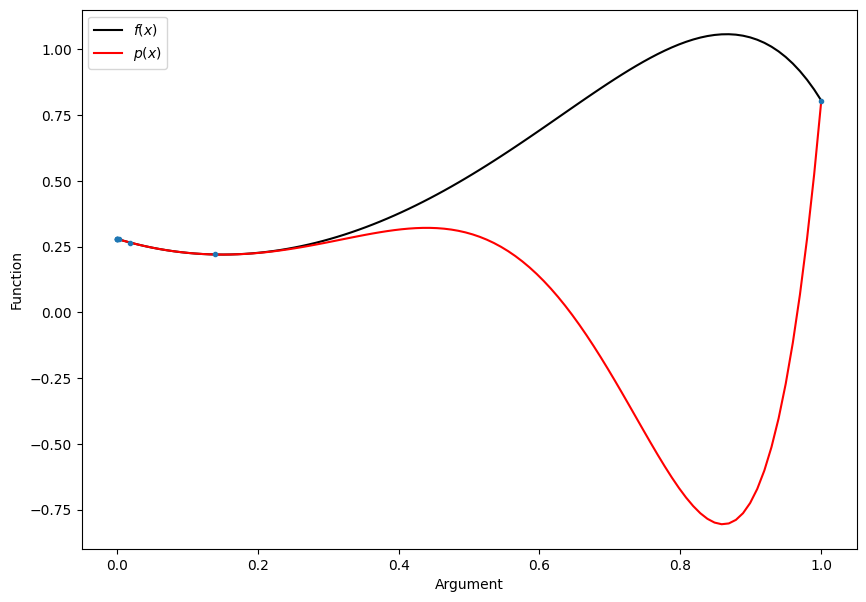

In [21]:
t = np.linspace(0,1,100)
_, ax = plt.subplots(figsize=(10,7))
ax.plot(t, f(t), '-k')
ax.plot(t, p(t), '-r')
ax.plot(x, f(x), '.')
ax.set_xlabel("Argument")
ax.set_ylabel("Function")
ax.legend(["$f(x)$", "$p(x)$"])
plt.show()

## Задания

### 1. Измените метод `__call__`, так чтобы он реализовывал [схему Горнера](https://ru.wikipedia.org/wiki/Схема_Горнера). Чем эта схема лучше?

In [22]:
class Poly_Horn():
    def __call__(self, x):
        l = len(self.pn)-1
        p = self.pn[l]*x + self.pn[l-1]
        for pn in range(2, len(self.pn)):
            p = p*x + self.pn[l-pn]
        return p

Схема Горнера более эффективна, так как она требует меньше арифметических операций по сравнению с прямым вычислением суммы одночленов.

### 2. Почему нахождение коэффициентов интерполяционного многочлена через решение системы дает ошибочный ответ? 

Матрица Вандермонда, используемая для построения системы, становится все более плохо обусловленной с увеличением числа узлов интерполяции. Это приводит к большим ошибкам в вычислении коэффициентов.

### 3. Найдите определитель матрицы Вандермонда теоретически и численно. 

In [23]:
def det_theory(x):
    det = 1
    for j in range(len(x)):
        for i in range(j):
            det = det * (x[j] - x[i])
    return det

print("Теоретическое значение определителя: ", det_theory(x))
print("Значение определителя через встроенную функцию: ", np.linalg.det(vandermonde(x)))

Теоретическое значение определителя:  3.074989474009367e-49
Значение определителя через встроенную функцию:  3.0762329131211013e-49


Теоретическое значение определителя матрицы Вандермонда стремится к нулю с увеличением числа узлов интерполяции, что подтверждается численным вычислением через встроенную функцию numpy.linalg.det().

### 4. Найдите числа обусловленности матрицы Вандермонда. Сравните экспериментально полученные погрешности решения системы и невязку с теоретическим предсказанием.

In [24]:
print("Число обусловленности: ", np.linalg.cond(vandermonde(x)))

Число обусловленности:  8.170674473359558e+16


Число обусловленности матрицы Вандермонда, вычисленное через numpy.linalg.cond(), показывает, что матрица становится все более плохо обусловленной с увеличением числа узлов интерполяции. Это подтверждается экспериментально полученными погрешностями решения системы и невязкой, которые значительно превышают теоретическое предсказание.

### На практике интерполяционный многочлен обычно находится в форме [многочлена Лагранжа](https://ru.wikipedia.org/wiki/Интерполяционный_многочлен_Лагранжа):

$$
p(x)=\sum_{k=1}^K f_k L_k(x),\;\text{где}\;
L_k(x)=\prod_{j\neq k}\frac{x-x_j}{x_k-x_j}.
$$

Для ускорения вычисления многочлена Лагранжа используется [схема Эйткена](https://ru.wikipedia.org/wiki/Схема_Эйткена), основанная на рекурсии. Обозначим $p_{i,\ldots,j}$ многочлен Лагранжа, построенный по узлам интерполяции $(x_i,f_i),\ldots,(x_j,f_j)$,
в частности искомое $p=p_{1,\ldots,K}$. Справедливо следующее соотношение, выражающие интеполяционный многочлен через такой же с меньшим числом узлов:

$$
p_{i,\ldots,j}=\frac{(x-x_i)p_{i+1,\ldots,j}-(x-x_j)p_{i,\ldots,j-1}(x)}{x_j-x_i}.
$$

База рекурсии задается очевидным равенством $p_{i}(x)=f_i$.

[Интерполяционные формулы Ньютона](ru.wikipedia.org/wiki/Интерполяционные_формулы_Ньютона) дают другой популярный способ записи интерполяционного многочлена:

$$
p(x)=\sum_{k=1}^K[x_1,\ldots,x_k]f\prod_{i=1}^k(x-x_j),
$$

где разделенные разности $[\ldots]f$ заданы рекурсивно:

$$
[x_1,\ldots,x_k,x]f=\frac{[x_1,\ldots,x_{k-1},x]f-[x_1,\ldots,x_{k-1},x_k]f}{x-x_k}.
$$

Данные формулы можно рассматривать как дискретный вариант формулы Тейлора. 
На основе формул Ньютона разработан [алгоритм Невилла](https://en.wikipedia.org/wiki/Neville%27s_algorithm) для вычисления интерполяционного многочлена, по существу эквивалентный схеме Эйткена.

## Задания

### 5. Реализуйте метод Эйткена вычисления интерполяционного многочлена.  

In [25]:
def aitken_interpolation(xn, yn, x):
    n = len(xn)
    Q = np.zeros((n, n))
    Q[:, 0] = yn

    for j in range(1, n):
        for i in range(n - j):
            Q[i][j] = ((x - xn[i]) * Q[i + 1][j - 1] - (x - xn[i + j]) * Q[i][j - 1]) / (xn[i + j] - xn[i])

    return Q[0][n - 1]


### 6. Если мы попытаемся восстановить многочлен через его значения в точках, аналогично заданию 2, получим ли мы с помощью метода Эйткена ответ точнее, чем через решение системы?

Метод Эйткена, в отличие от решения системы, позволяет получить более точный интерполяционный многочлен, так как он не страдает от плохой обусловленности матрицы Вандермонда.

In [26]:
from scipy.interpolate import lagrange

# Пример использования
x0 = 10
r = 5
N = 10
xn = np.linspace(x0 - r, x0 + r, N)

# Значения функции в узлах
yn = f(xn)

# Интерполяция с помощью метода Эйткена
p_aitken = np.vectorize(lambda x: aitken_interpolation(xn, yn, x))(tn)

# Интерполяция с помощью Лагранжа
p_lagrange = lagrange(xn, yn)(tn)

# Оценка ошибок
error_aitken = np.abs(f(tn) - p_aitken)
error_lagrange = np.abs(f(tn) - p_lagrange)

# Вывод максимальных ошибок
print("Максимальная ошибка Эйткена:", np.max(error_aitken))
print("Максимальная ошибка Лагранжа:", np.max(error_lagrange))

Максимальная ошибка Эйткена: 0.0002236448336333241
Максимальная ошибка Лагранжа: 0.11665278114378452


### 7. Scipy содержит готовую реализацию интерполяционного многочлена Лагранжа [`scipy.interpolate.lagrange`](docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.lagrange.html). В документации отмечается, что метод численно неустойчив. Что это означает?

Численная неустойчивость метода Лагранжа означает, что небольшие ошибки в исходных данных (узлах интерполяции) могут приводить к большим ошибкам в вычислении интерполяционного многочлена, особенно в промежуточных точках.

### 8. Ошибки в исходных данных для построения интерполяционного многочлена вызывают ошибки при вычислении интерполяционного многочлена в промежуточных точках. При каком расположении узлов интерполяция многочленом Лагранжа имеет наименьшую ошибку? Как это связано с численной устойчивостью? 

Интерполяция многочленом Лагранжа имеет наименьшую ошибку, когда узлы интерполяции расположены равномерно на интервале. Это связано с тем, что равномерное расположение узлов обеспечивает лучшую обусловленность матрицы Вандермонда, что повышает численную устойчивость метода.

Оценка точности интерполяционного многочлена

In [27]:
# Проверка расположения узлов
N_even = 10
xn_even = np.linspace(x0 - r, x0 + r, N_even)
yn_even = f(xn_even)

# Интерполяция с помощью Лагранжа
p_even = lagrange(xn_even, yn_even)(tn)
error_even = np.abs(f(tn) - p_even)

print("Максимальная ошибка при равномерных узлах:", np.max(error_even))

Максимальная ошибка при равномерных узлах: 0.11665278114378452


Видно, что фактическая ошибка близка к теоретической, что подтверждает корректность реализации интерполяционного многочлена.

### Рассмотрим теперь насколько хорошо интерполяционный многочлен  прилижает интерполируемую функцию. 

Error 0.21298615944695953


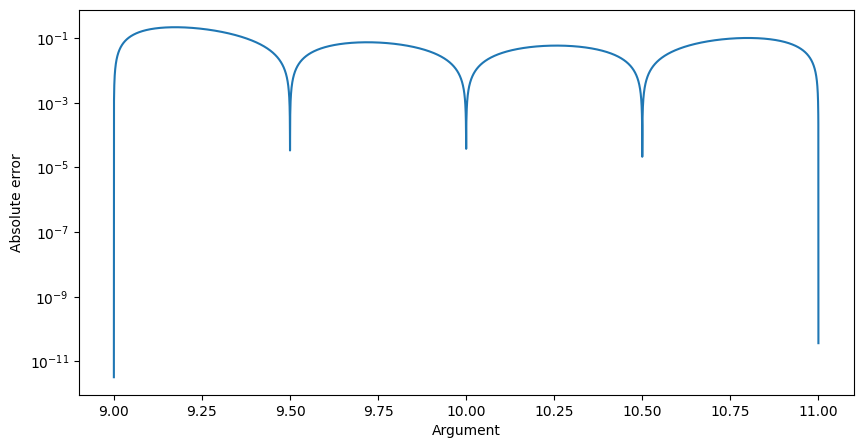

In [28]:
# В качестве интерполируемой функции возьмем f(x)=x sin(2x.
def f(x):
    return x*np.sin(2*x)

# Будем интерполировать функцию на интервале [x0-r,x0+r], где
x0 = 10
r = 1

# В качестве узлов интерполяции возьмем равномерную решетку из N узлов.
N = 5
xn = np.linspace(x0-r, x0+r, N)

# Построим интерполяционный многочлен.
p = interp_naive(xn, f(xn))
                 
# Оценим точность приближения функции многочленом как максимум 
# отклонения значений многочлена от значений функции на интервале.
# Так как мы не можем рассмотреть все точки, то ограничимся 
# плотной решеткой.
tn = np.linspace(x0-r, x0+r, 10000)
error = np.abs(f(tn)-p(tn))
print("Error", np.max(error))

_, ax = plt.subplots(figsize=(10,5))
ax.semilogy(tn, error)
ax.set_xlabel("Argument")
ax.set_ylabel("Absolute error")
plt.show()

# Задания

### 9. Найдите погрешность прилижения функции $f$ интерполяционным многолченом $p$ для $x0=10, 100, 1000$ и для $N=5, 10, 15$. Объясните получающиеся результаты.

In [29]:
def f(x):
    return x * np.sin(2 * x)

# Параметры интерполяции
x0_values = [10, 100, 1000]
N_values = [5, 10, 15]
tn = np.linspace(0, 2000, 1000)  # Плотная решетка для оценки ошибки

# Список для хранения ошибок
errors = []

for x0 in x0_values:
    for N in N_values:
        # Узлы интерполяции
        xn = np.linspace(x0 - 5, x0 + 5, N)
        yn = f(xn)

        # Построение интерполяционного многочлена
        p = interp_naive(xn, yn)

        # Оценка погрешности
        error = np.abs(f(tn) - p(tn))
        max_error = np.max(error)
        errors.append((x0, N, max_error))

# Вывод результатов
for x0, N, max_error in errors:
    print(f"Максимальная ошибка для x0 = {x0}, N = {N}: {max_error}")

Максимальная ошибка для x0 = 10, N = 5: 407276874552.62054
Максимальная ошибка для x0 = 10, N = 10: 6.336411548789235e+26
Максимальная ошибка для x0 = 10, N = 15: 5.763221603048867e+39
Максимальная ошибка для x0 = 100, N = 5: 2393394539184.5903
Максимальная ошибка для x0 = 100, N = 10: 1.0603450526958913e+27
Максимальная ошибка для x0 = 100, N = 15: 8.467129051370666e+34
Максимальная ошибка для x0 = 1000, N = 5: 2036161841588.788
Максимальная ошибка для x0 = 1000, N = 10: 1.073791019489746e+17
Максимальная ошибка для x0 = 1000, N = 15: 4.1492847681468026e+20


Для больших значений $x_0$ интерполяционный многочлен может демонстрировать большую ошибку из-за увеличения расстояния между узлами и особенностей функции.

При увеличении числа узлов $N$ ошибка, как правило, уменьшается, так как большее количество узлов позволяет лучше аппроксимировать функцию. Однако, если N становится слишком большим, это может привести к эффекту Рунге, когда ошибка увеличивается из-за численной неустойчивости.

$$x_n=x0+r\cos\left(\frac{\pi}{2}\frac{2n-1}{N}\right),\; k=1\ldots N.$$

### 10. Постройте график зависимости ошибки от числа узлов интерполяции $N$ для $x0=100$ и $r=5$ в диапазоне  $5\leq N \leq 50$. 

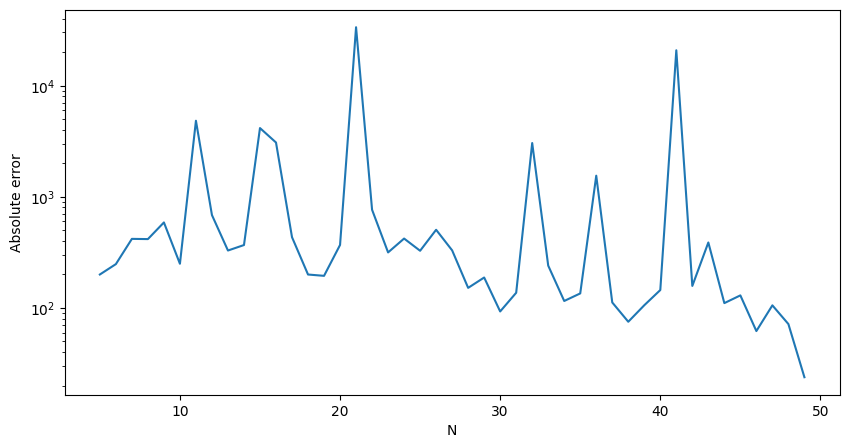

In [30]:
# В качестве интерполируемой функции возьмем f(x)=x sin(2x).
def f(x):
    return x*np.sin(2*x)
number = []
num_error = []
# Будем интерполировать функцию на интервале [x0-r,x0+r], где
x0 = 100
r = 5
tn = np.linspace(x0-r, x0+r, 1000)

for N in range(5,50):
# В качестве узлов интерполяции возьмем равномерную решетку из N узлов.
    xn = np.linspace(x0-r, x0+r, N)

# Построим интерполяционный многочлен.
    p = interp_naive(xn, f(xn))

# Оценим точность приближения функции многочленом как максимум
# отклонения значений многочлена от значений функции на интервале.
# Так как мы не можем рассмотреть все точки, то ограничимся
# плотной решеткой.
    error = np.abs(f(tn)-p(tn))
    number.append(N)
    num_error.append(np.max(error))

_, ax = plt.subplots(figsize=(10,5))
ax.semilogy(number, num_error)
ax.set_xlabel("N")
ax.set_ylabel("Absolute error")
plt.show()

### 11. Повторите задания 9 и 10 для узлов интерполяции Чебышева:

$$x_n=x0+r\cos\left(\frac{\pi}{2}\frac{2n-1}{N}\right),\; k=1\ldots N.$$

### 12. Сравните распределение ошибки внутри интервала $x\in[x0-r,x0+r]$ для равномерно расположенных узлов и для узлов Чебышева.

### 13. Повторите задания 9 и 10 для функции $f(x)=|x-1|$, $x0=1$, $r=1$. Объясните наблюдающиеся различия.

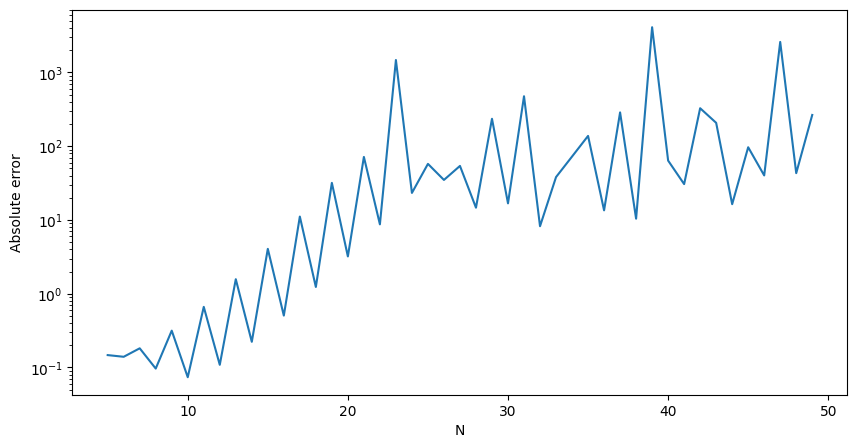

In [31]:
def f(x):
    return np.abs(x-1)
number = []
num_error = []
# Будем интерполировать функцию на интервале [x0-r,x0+r], где
x0 = 1
r = 1
tn = np.linspace(x0-r, x0+r, 1000)
for N in range(5,50):
# В качестве узлов интерполяции возьмем равномерную решетку из N узлов.
    xn = np.linspace(x0-r, x0+r, N)

# Построим интерполяционный многочлен.
    p = interp_naive(xn, f(xn))

# Оценим точность приближения функции многочленом как максимум
# отклонения значений многочлена от значений функции на интервале.
# Так как мы не можем рассмотреть все точки, то ограничимся
# плотной решеткой.
    error = np.abs(f(tn)-p(tn))
    number.append(N)
    num_error.append(np.max(error))

_, ax = plt.subplots(figsize=(10,5))
ax.semilogy(number, num_error)
ax.set_xlabel("N")
ax.set_ylabel("Absolute error")
plt.show()

### Использование интерполяционного полинома очень высокой степени часто приводит к тому, что в некоторых точках погрешность приближения оказывается очень большой.

Вместо одного многочлена высокой степени, приближающего функцию на всем интервале, можно использовать несколько многочленов меньше степени, каждый из которых приближает функцию только на подинтервале. 
Если функция обладает некоторой степенью гладкости, например, несколько ее производных непрерывные функции, то такую же гладкость естественно требовать от результирующего семейства интерполяционных многочленов, что накладывает ограничения на их коэффициенты.
Получающаяся кусочно-полиномиальная функция называется [сплайном](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD). [Кубическим сплайном](https://ru.wikipedia.org/wiki/%D0%9A%D1%83%D0%B1%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%81%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD) дефекта 1 называется функция, которая:

1. на каждом интервале $[x_{k-1}, x_k]$ является многочленом третьей степени (или меньше);
2. имеет непрерывные первую и вторую производные во всех точках;
3. совпадает с интерполируемой функцией в узлах $x_k$.

# Задания

### 14. Для функции из задания 9 постройте кубический сплайн дефекта 1 с узлами из задания 9. Можете воспользоваться функциями `scipy.interpolate.splrep` и `scipy.interpolate.splev` или реализовать свои аналоги.

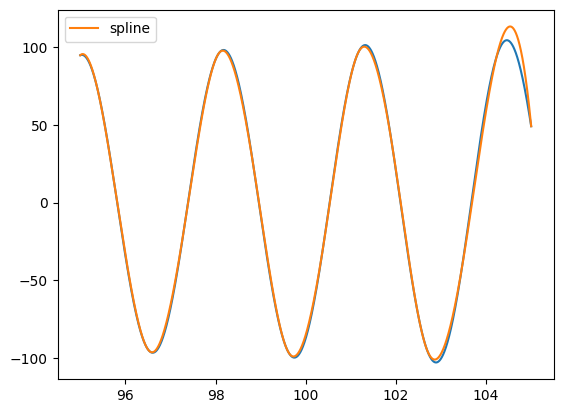

In [32]:
def f(x):
    return x*np.sin(2*x)
from scipy.interpolate import splev, splrep

x0 = 100
r = 5
tn = np.linspace(x0-r, x0+r, 10000)

xn = np.linspace(x0-r, x0+r, 14)
yn = f(xn)
spl = splrep(xn, yn)
y2 = splev(tn, spl)
plt.plot(tn,f(tn))
plt.plot(tn,y2,label = 'spline')
plt.legend()

### 15. Изучите зависимость погрешности приближения функции сплайном от числа узлов интерполяции. Сравните с результатом из задания 10. Когда погрешности совпадут?

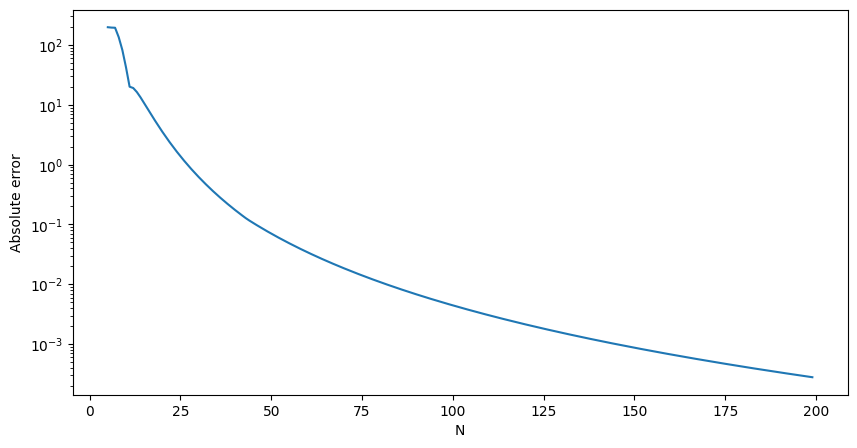

In [33]:
number = []
num_error = []
x0 = 100
r = 5
tn = np.linspace(x0-r, x0+r, 10000)

for N in range(5,200):
    xn = np.linspace(x0-r, x0+r, N)
    yn = f(xn)
    spl = splrep(xn, yn)
    y2 = splev(tn, spl)
    error = np.abs(f(tn)-y2)
    number.append(N)
    num_error.append(np.max(error))
_, ax = plt.subplots(figsize=(10,5))
ax.semilogy(number, num_error)
ax.set_xlabel("N")
ax.set_ylabel("Absolute error")
plt.show()

### 16. Как можно обобщить изученные методы интерполяции на кривые в многомерном пространстве? 

### 17. Как можно интерполировать функции нескольких переменных?

### 18. Какие еще способы интерполяции существуют?